In [2]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline
import random

In [3]:
import torchvision
import torchvision.transforms as transforms

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available now:', device)

Device available now: cuda


In [5]:
image_transforms = transforms.Compose(
         [transforms.ToTensor(),
         transforms.CenterCrop(28),
         transforms.Normalize((0.5), (0.5))]
)

In [6]:
batchsize = 32
rowsize = 28
colsize = 28
inchannels = 3
kernelsize = 5
stride = 1
padding = 0
poolsize = 3
fc_size1 = 384
fc_size2 = 192
no_classes = 10
epochs = 100
overfit_accuracy = 90

In [7]:
alex_overfitcounts = []
alex_testaccuracies = []

In [8]:
train = torchvision.datasets.CIFAR10(root='./', train=True, download=True, transform=image_transforms)
test = torchvision.datasets.CIFAR10(root='./', train=False, transform=image_transforms)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./


In [9]:
trainindices = list(range(0, len(train), 10))
testindices = list(range(0, len(test),10))
trainset = torch.utils.data.Subset(train,trainindices)
testset = torch.utils.data.Subset(test,testindices)

In [10]:
print(len(trainset))

5000


In [11]:
traindata = torch.utils.data.DataLoader(trainset,batch_size=batchsize, shuffle=False, num_workers=2,pin_memory=True)
testdata = torch.utils.data.DataLoader(testset,batch_size=batchsize, shuffle=False, num_workers=2,pin_memory=True)

In [12]:
train_labels = torch.zeros(len(traindata)*batchsize)
test_labels = torch.zeros(len(testdata)*batchsize)
trainnum = 0
testnum = 0
for i,data in enumerate(traindata):
  for j in range(len(data[1])):
    train_labels[trainnum] = data[1][j]
    trainnum+=1
for i,data in enumerate(testdata):
  for j in range(len(data[1])):
    test_labels[testnum] = data[1][j]
    testnum+=1
  

In [13]:
class SimpleAlex(nn.Module):
  def __init__(self,inchannels,kernelsize,stride,padding,poolsize,fc_size1,fc_size2,no_classes):
    super(SimpleAlex, self).__init__()
    self.conv1 = nn.Conv2d(inchannels,24,kernelsize,stride,padding)
    self.pool1 = nn.MaxPool2d(poolsize,2)
    self.BatchNorm1 = nn.BatchNorm2d(24)
    self.conv2 = nn.Conv2d(24,48,kernelsize,stride,padding)
    self.pool2 = nn.MaxPool2d(poolsize,2)
    self.BatchNorm2 = nn.BatchNorm2d(48)
    self.fc1 = nn.Linear(432,fc_size1)
    self.fc2 = nn.Linear(fc_size1,fc_size2)
    self.fc3 = nn.Linear(fc_size2,no_classes) 

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = self.BatchNorm1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    x = self.BatchNorm2(x)
    x = torch.flatten(x,1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    return x

In [14]:
model = SimpleAlex(inchannels,kernelsize,stride,padding,poolsize,fc_size1,fc_size2,no_classes).to(device)
# model = SimpleAlex(no_classes).to(device)

In [15]:
optimizer = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay = 0.005, momentum = 0.9)
criterion = nn.CrossEntropyLoss().to(device)

In [16]:
# def training(model,traindata,testdata):
def training(model,traindata,testdata,optimizer,train_labels,test_labels):
  test_accuracies = []
  test_accuracies.append(0)
  test_accuracies.append(0)
  test_accuracies.append(0)
  count=0
  flag=0
  prev = 0
  for ep in range(epochs):
    Loss = 0
    num_correct=0
    tot = 0
    testnum = 0
    trainnum = 0
    for i,data in enumerate(traindata):
      x_data = data[0].to(device)
      labels = data[1].to(device)
      for j in range(len(x_data)):
        labels[j] = train_labels[trainnum]
        trainnum+=1
      optimizer.zero_grad()
      outputs = model(x_data)
      _, pred = torch.max(outputs.data, 1)
      num_correct += (pred == labels).sum().item()
      tot += labels.size(0)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      Loss += loss
    print("Accuracy : ",num_correct/tot)
    print("Loss : ",loss)
    if((num_correct/tot) - prev < 0.001):
      flag=1
    prev =  num_correct/tot
    with torch.no_grad():
      correct = 0
      total = 0
      for i,data in enumerate(testdata):
          images = data[0]
          labels = data[1]
          images = images.to(device)
          labels = labels.to(device)
          for j in range(len(images)):
             labels[j] = test_labels[testnum]
             testnum+=1
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item() 
      test_accuracies.append(100*correct/total)
      if flag==1:
        alex_overfitcounts.append(count+1)
        alex_testaccuracies.append(100*correct/total)
        break
      print("Accuracy of the on test images : ",100 * correct / total)
      count+=1
      if flag==1:
        break

In [17]:
per = 0
for i in range(6):
  model = SimpleAlex(inchannels,kernelsize,stride,padding,poolsize,fc_size1,fc_size2,no_classes).to(device)
  optimizer = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay = 0.005, momentum = 0.9)
  train_labels = torch.zeros(len(traindata)*batchsize)
  test_labels = torch.zeros(len(testdata)*batchsize)
  trainnum = 0
  testnum = 0
  for i,data in enumerate(traindata):
    for j in range(len(data[1])):
      train_labels[trainnum] = data[1][j]
      trainnum+=1
  for i,data in enumerate(testdata):
    for j in range(len(data[1])):
      test_labels[testnum] = data[1][j]
      testnum+=1
  print("-------------------------------------")
  localtraining_data = traindata
  localtest_data = testdata
  if per!=0:
    trainls = random.sample(range(0,(len(traindata)*batchsize)),int((len(traindata)*batchsize)*per/100))
    testls = random.sample(range(0,(len(testdata)*batchsize)),int((len(testdata)*batchsize)*per/100))
    trainls.sort()
    testls.sort()
    for i in range(len(trainls)):
      train_labels[trainls[i]] = random.randint(0,9)
    for i in range(len(testls)):
      test_labels[testls[i]] = random.randint(0,9)
  training(model,localtraining_data,localtest_data,optimizer,train_labels,test_labels)
  per+=20

-------------------------------------
Accuracy :  0.2816
Loss :  tensor(2.1564, device='cuda:0', grad_fn=<NllLossBackward0>)
Accuracy of the on test images :  34.0
Accuracy :  0.419
Loss :  tensor(1.6106, device='cuda:0', grad_fn=<NllLossBackward0>)
Accuracy of the on test images :  42.2
Accuracy :  0.489
Loss :  tensor(1.1635, device='cuda:0', grad_fn=<NllLossBackward0>)
Accuracy of the on test images :  45.5
Accuracy :  0.5534
Loss :  tensor(0.8144, device='cuda:0', grad_fn=<NllLossBackward0>)
Accuracy of the on test images :  48.2
Accuracy :  0.5946
Loss :  tensor(0.5306, device='cuda:0', grad_fn=<NllLossBackward0>)
Accuracy of the on test images :  47.2
Accuracy :  0.6362
Loss :  tensor(0.3670, device='cuda:0', grad_fn=<NllLossBackward0>)
Accuracy of the on test images :  47.3
Accuracy :  0.6738
Loss :  tensor(0.2846, device='cuda:0', grad_fn=<NllLossBackward0>)
Accuracy of the on test images :  47.6
Accuracy :  0.6958
Loss :  tensor(0.3797, device='cuda:0', grad_fn=<NllLossBackwar

In [18]:
print(alex_overfitcounts)

[18, 21, 28, 24, 30, 19]


In [19]:
print(alex_testaccuracies)

[45.6, 31.9, 23.5, 16.0, 11.7, 10.4]


Text(0.5, 1.0, 'Simple Alex')

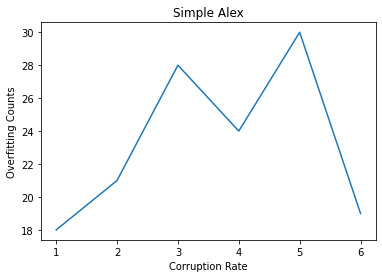

In [20]:
p = [1,2,3,4,5,6]
plt.plot(p,alex_overfitcounts)
plt.xlabel("Corruption Rate")
plt.ylabel("Overfitting Counts")
plt.title("Simple Alex")

Text(0.5, 1.0, 'Simple Alex')

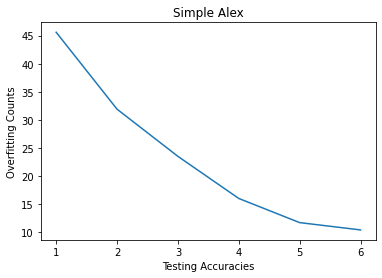

In [21]:
plt.plot(p,alex_testaccuracies)
plt.xlabel("Testing Accuracies")
plt.ylabel("Overfitting Counts")
plt.title("Simple Alex")